In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad_vec
from scipy.fft import fftshift, ifft
from joblib import Parallel, delayed

# Define the grid size
n = 32

# Generate the grid around zero, excluding the origin
def generate_grid(grid_size):
    coords = np.arange(-grid_size // 2, grid_size // 2 + 1)
    grid = [(int(k1), int(k2)) for k1 in coords for k2 in coords if not (k1 == 0 and k2 == 0)]
    return grid

# Define the characteristic function of the sum of chi-squared variables
# def characteristic_function(t, grid_size):
#     phi = 1
#     for k1 in range(1, grid_size + 1):
#         for k2 in range(1, grid_size + 1):
#             k_squared = k1**2 + k2**2
#             phi *= (1 - 2j * t / k_squared) ** (-1 / 2)
#     return phi

def characteristic_function(t, grid):
    """Compute the characteristic function of S."""
    phi = 1
    for k1, k2 in grid:
        k_norm_sq = k1**2 + k2**2
        phi *= (1 - 2j * t / k_norm_sq) ** (-1 / 2)
    return phi

def integrand(t, s, grid):
    """Integrand for the inverse Fourier transform to compute the PDF."""
    return np.real(characteristic_function(t, grid) * np.exp(-1j * t * s))

def pdf_via_adaptive_integration(s, grid, t_max=100, num_intervals=10):
    """Compute the PDF by splitting the integration range into smaller intervals."""
    t_vals = np.linspace(-t_max, t_max, num_intervals + 1)
    result = 0
    for i in range(num_intervals):
        part, _ = quad_vec(integrand, t_vals[i], t_vals[i + 1], args=(s, grid))
        result += part
    return result / (2 * np.pi)

def sanity_check_pdf_normalization(s_vals, pdf_vals):
    # Numerical integration using the trapezoidal rule to check if the PDF integrates to 1
    integral = np.trapezoid(pdf_vals, s_vals)
    return integral

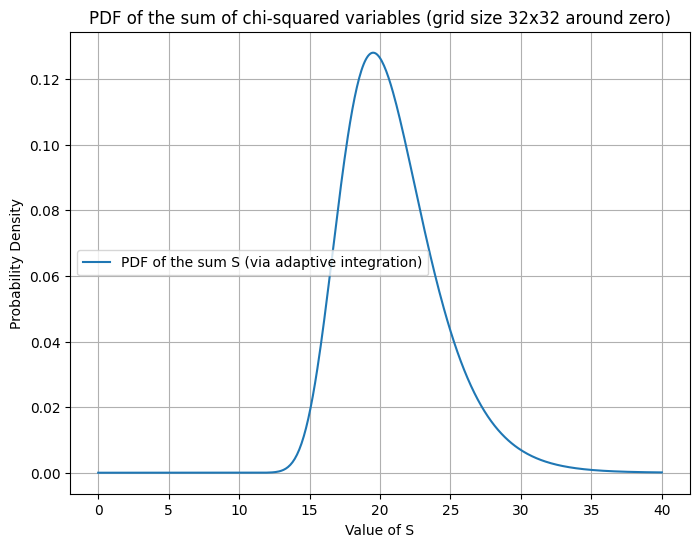

In [48]:
# Generate a range of s values (from 0 to a reasonable upper limit, say 20)
t_max = 400
# Use parallel processing to compute the PDF
grid = generate_grid(n)  # Generate the new grid
s_vals_integration = np.linspace(0, 40, 500)
pdf_vals_integration = Parallel(n_jobs=-1)(
    delayed(pdf_via_adaptive_integration)(s, grid, t_max=400, num_intervals=20) for s in s_vals_integration
)
# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(s_vals_integration, pdf_vals_integration, label='PDF of the sum S (via adaptive integration)')
plt.title(f'PDF of the sum of chi-squared variables (grid size {n}x{n} around zero)')
plt.xlabel('Value of S')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

Gamma Params: shape=400000006.5182662, loc=-231382.4537799817, scale=0.0005785061250185904
Chi-squared Params: df=79.36271688414294, loc=-53.54670999955701, scale=0.9260849884380016


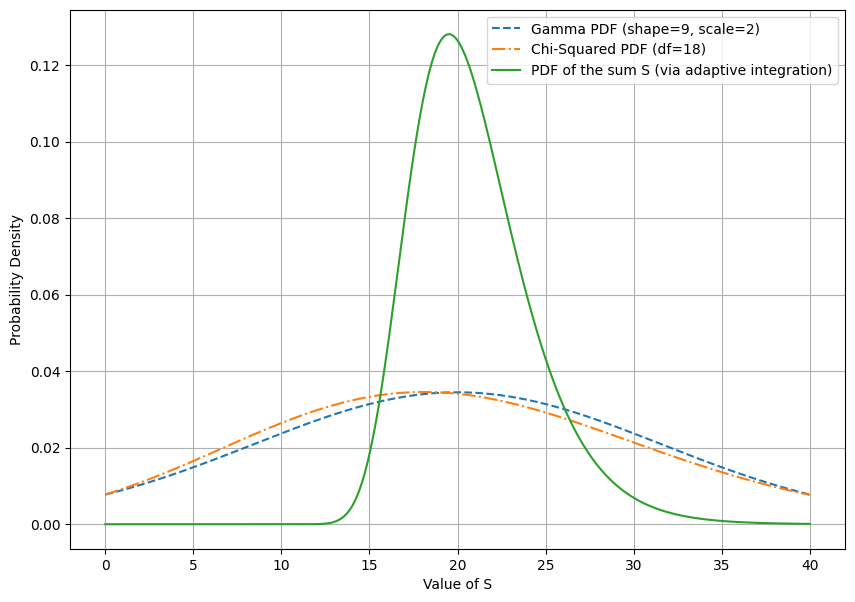

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, chi2

# Fit the Gamma distribution to your data
gamma_params = gamma.fit(s_vals_integration)
print(f"Gamma Params: shape={gamma_params[0]}, loc={gamma_params[1]}, scale={gamma_params[2]}")

# Fit the Chi-squared distribution to your data
chi2_params = chi2.fit(s_vals_integration)
print(f"Chi-squared Params: df={chi2_params[0]}, loc={chi2_params[1]}, scale={chi2_params[2]}")

gamma_fitted_pdf = gamma.pdf(s_vals_integration, *gamma_params)
chi2_fitted_pdf = chi2.pdf(s_vals_integration, *chi2_params)

# Plot the original plot (assuming it resembles a probability density function)
plt.figure(figsize=(10, 7))
plt.plot(s_vals_integration, gamma_fitted_pdf, label='Gamma PDF (shape=9, scale=2)', linestyle='--')
plt.plot(s_vals_integration, chi2_fitted_pdf, label='Chi-Squared PDF (df=18)', linestyle='-.')
plt.plot(s_vals_integration, pdf_vals_integration, label='PDF of the sum S (via adaptive integration)')
plt.xlabel('Value of S')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# Perform the sanity check
normalization_check = sanity_check_pdf_normalization(s_vals_integration, pdf_vals_integration)

# Display the result of the sanity check
normalization_check

np.float64(0.9997942999217199)

## Changing the characteristic function definition to use the grid